In [1]:
%run setup
%load_ext autoreload
%autoreload 2

In [242]:
from IPython.display import Image
from pathlib import Path
from nlp_intro.data import draw_uniform_data
from nlp_intro.figure_factory import Linear2D2ClassModelPlotter, plot_3d_scatter, gradient_descent_animation
import pandas as pd
import numpy as np
from nlp_intro.logistic_regression import gradient

In [3]:
root_dir = Path("..").resolve()

# Mål for presentasjonen

- Kommer ikke til å gå i dybden på de forskjellige algortimene
- Dette kommer til å være en praktisk 

# Maskinlæring på 5 minutter

# 2 typer maskinlæring

1. **Veiledet læring** (en: supervised learning): metoder for å lære seg en sammenheng mellom data og kategorier/tallverdier tillordnet denne dataen, slik at man gitt ny data kan predikere disse kategoriene/tallverdiene

2. **Ikke-veilede læring** (en: unsupervised learning): metoder for å finne nyttige mønstre i data

 ## Veiledet læring

 
<center> <img src="../images/bender.gif"/> </center>

Vi har datapunkter $X$ og for hvert datapunkt en kategori/tallverdi $y$. Vi antar at det er en sammenheng mellom $X$ og $y$, slik at $X$ kan brukes for å predikere $y$:
$$X \rightarrow y$$

Ved hjelp av *veiledet læring* ønsker vi å finne denne "pilen"/modellen:
$$X \boxed{\rightarrow} y$$

..slik at gitt nye datapunkter $X_2$ og modellen:
$$X_2 \rightarrow $$

...kan vi produsere prediksjoner for hvert av de nye datapunktene:
$$X_2 \rightarrow y_2$$

## Eksempel: et datasett av bokser

<center> <img src="../images/boxes1.png"  style="height:200px;width:auto;"/> </center>

In [34]:
data = draw_uniform_data(100, (0, 1), (0, 1))
feature_names = ("width", "height")
pd.DataFrame(data, columns=feature_names).head(3)

,width,height
0,0.207300,0.258934
1,0.785209,0.880128
2,0.011815,0.195721


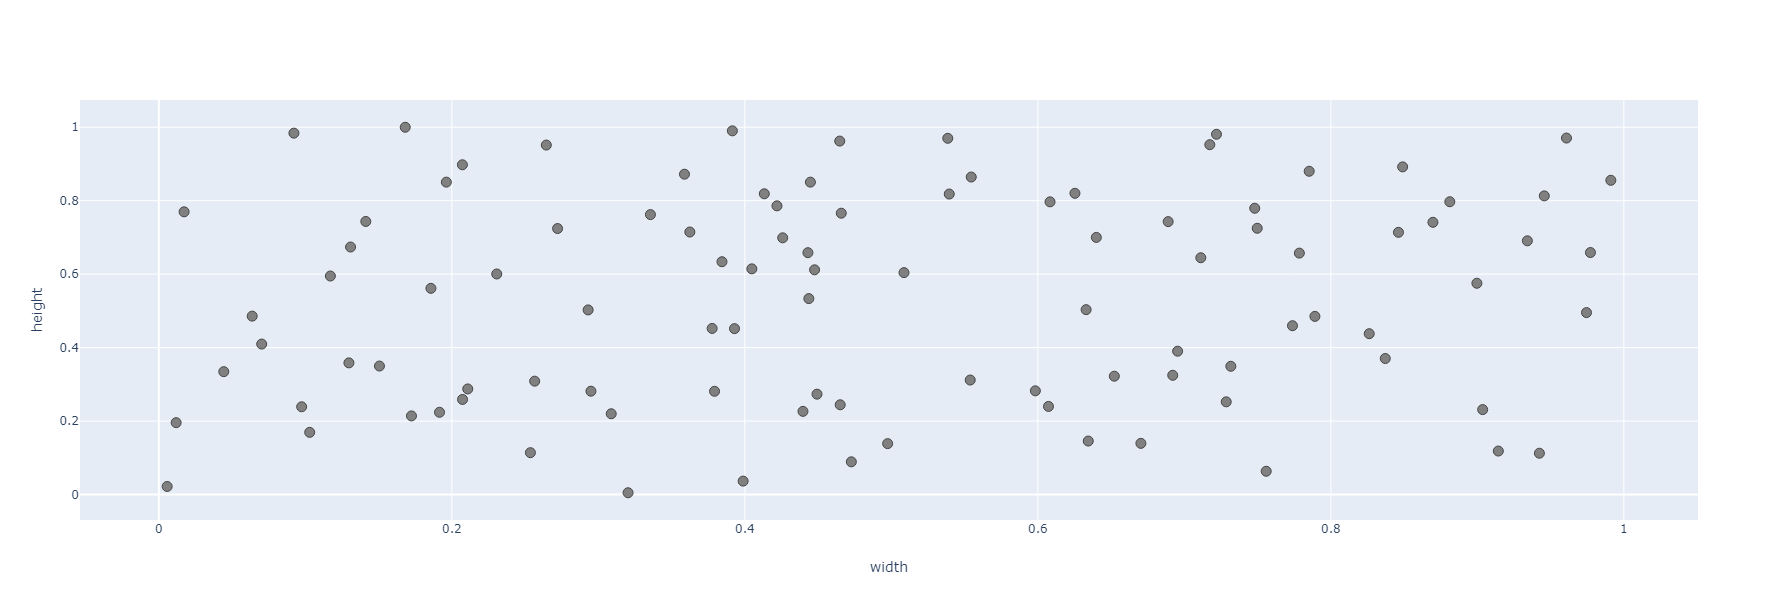

In [35]:
layout = dict(width=800, height=600, yaxis=dict(title_text="height"), xaxis=dict(title_text="width"))
plotter = Linear2D2ClassModelPlotter((0,1), (0,1), layout=layout)
plotter.update_data_plots(data)
plotter()

### En lineær modell for boks-dataen

Er dette en god modell for boks-dataen vår?

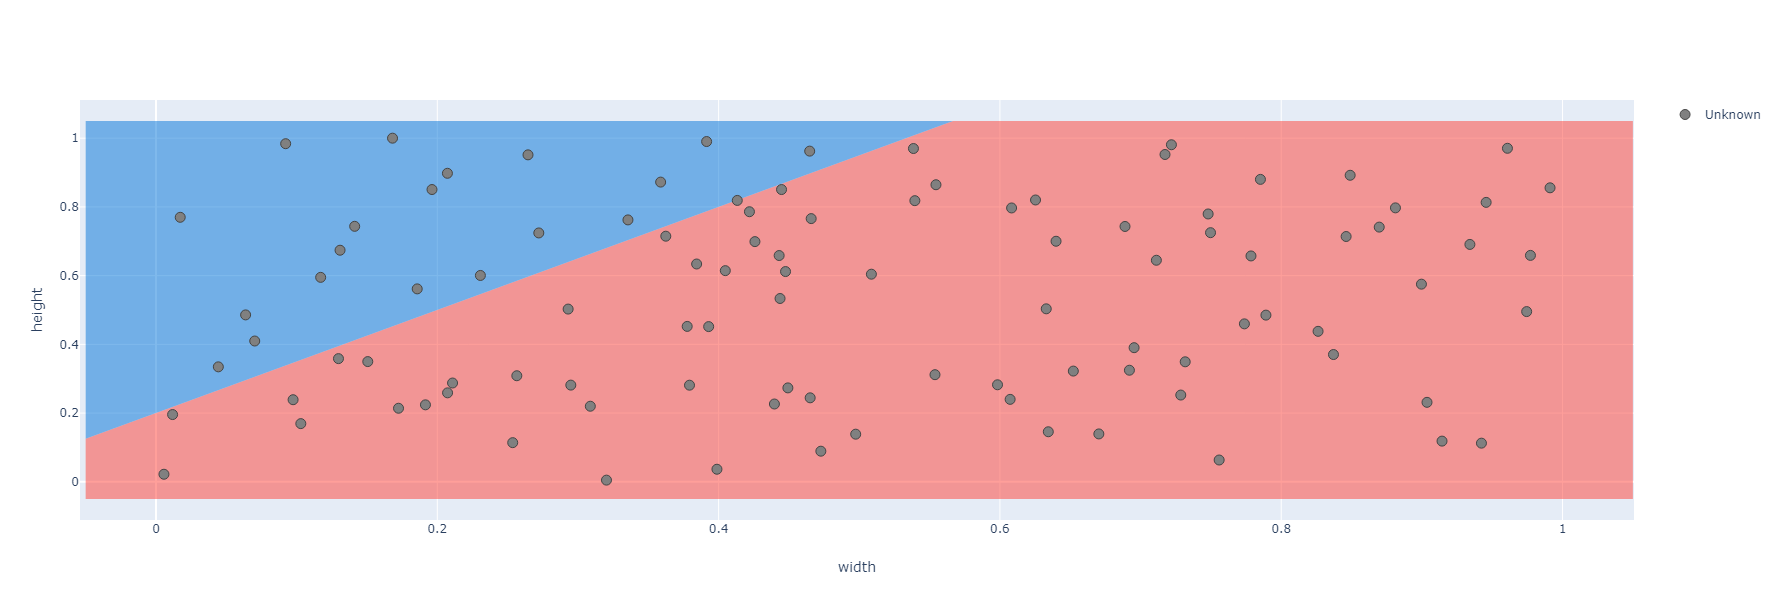

In [38]:
plotter.update_model_area_plots(lambda x: 1.5*x+0.2)
plotter()

Umulig å vite. For å kunne en veiledet modell trenger vi noe som kan veilede modellen.

In [39]:
def predict(boolean_model, data, class_names):
    label_ids = boolean_model(data)
    label_names = np.asarray(class_names)
    return label_names[label_ids.astype(int)]

### Tagging av hvert datapunkt

- For å veilede modellen vår må hvert punkt tagges med en kategori eller tallverdi.
- Mange potensielle måter å tagge boks-datapunktene våre, men én mulighet er å skille mellom "vide" og "høye" rektangler

<center> <img src="../images/rectangle-classes.png"  style="height:600px;width:auto;"/> </center>

Vi vil da få et datasett på følgende format:

In [50]:
class_names = ["Tall rectangle", "Wide rectangle"]
model = lambda data: data[:,0] > data[:,1]
labels = predict(model, data, class_names)
pd.DataFrame(np.asarray([*data.T, labels]).T, columns=("width", "height", "class")).head(5)

,width,height,class
0,0.20729979472648374,0.25893447150629323,Tall rectangle
1,0.7852087214162017,0.8801282601490411,Tall rectangle
2,0.011815321573685478,0.19572097934214994,Tall rectangle
3,0.25361835400399335,0.11398602427303439,Wide rectangle
4,0.39147726744087674,0.9902341168393478,Tall rectangle


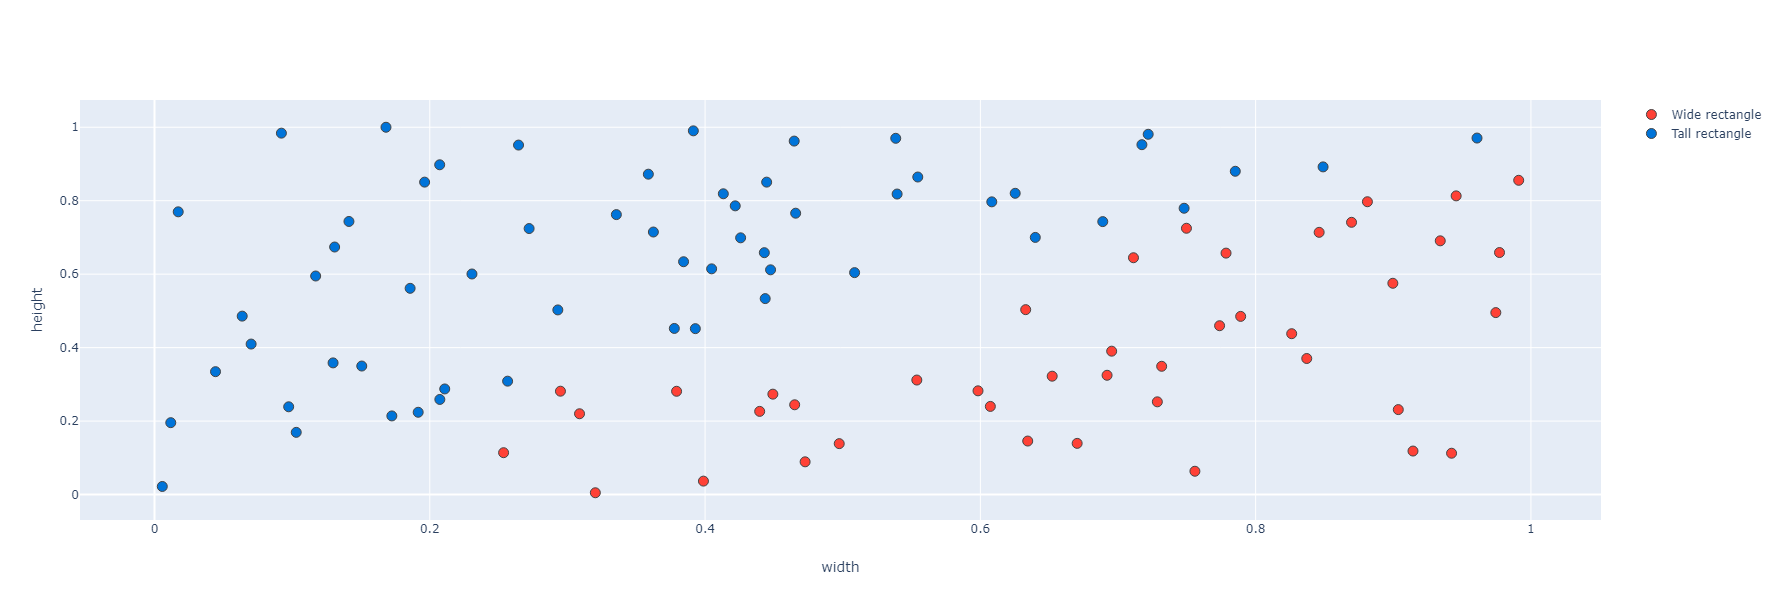

In [51]:
plotter.disable_model_areas()
plotter.update_data_plots(data, labels, unq_classes=class_names[::-1])
plotter()

### En lineær modell for å skille mellom vide og høye rektangler

For å skille disse punktene fra hverandre kan vi trene en lineær modell vha veiledet læring. Kan vi nå si om modellen er god eller ikke?

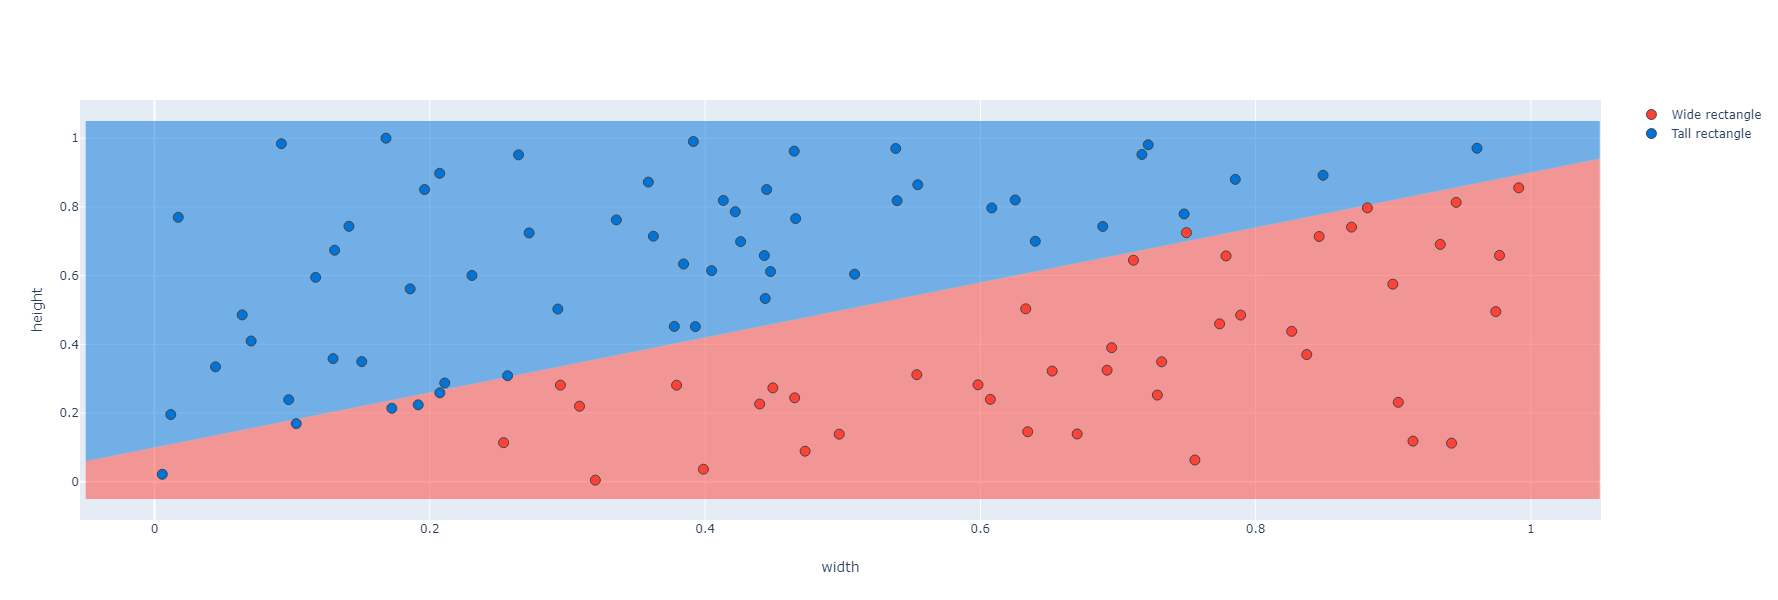

In [54]:
lin_model = lambda x: 0.8*x + 0.1
plotter.enable_model_areas()
plotter.update_model_area_plots(lin_model)
plotter()

Ja, vi kan nå bruke kategoriene i datasettet vårt for å avgjøre om modellen er god eller om den må justeres.

Med en trent modell kan vi gjøre prediksjoner for nye datapunkter. Vi kan da "kaste vekk" all dataen vi brukte for å trene den.

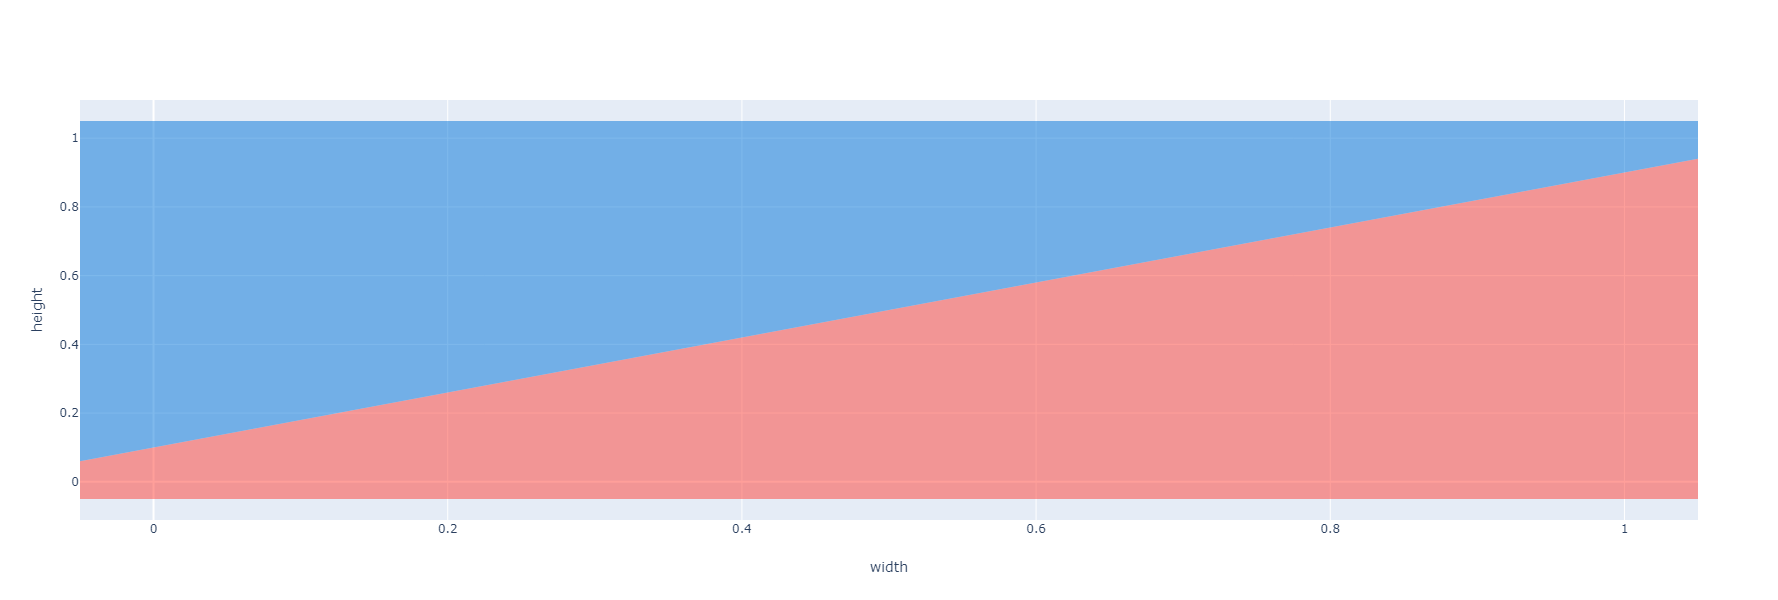

In [56]:
plotter.disable_data_points()
plotter()

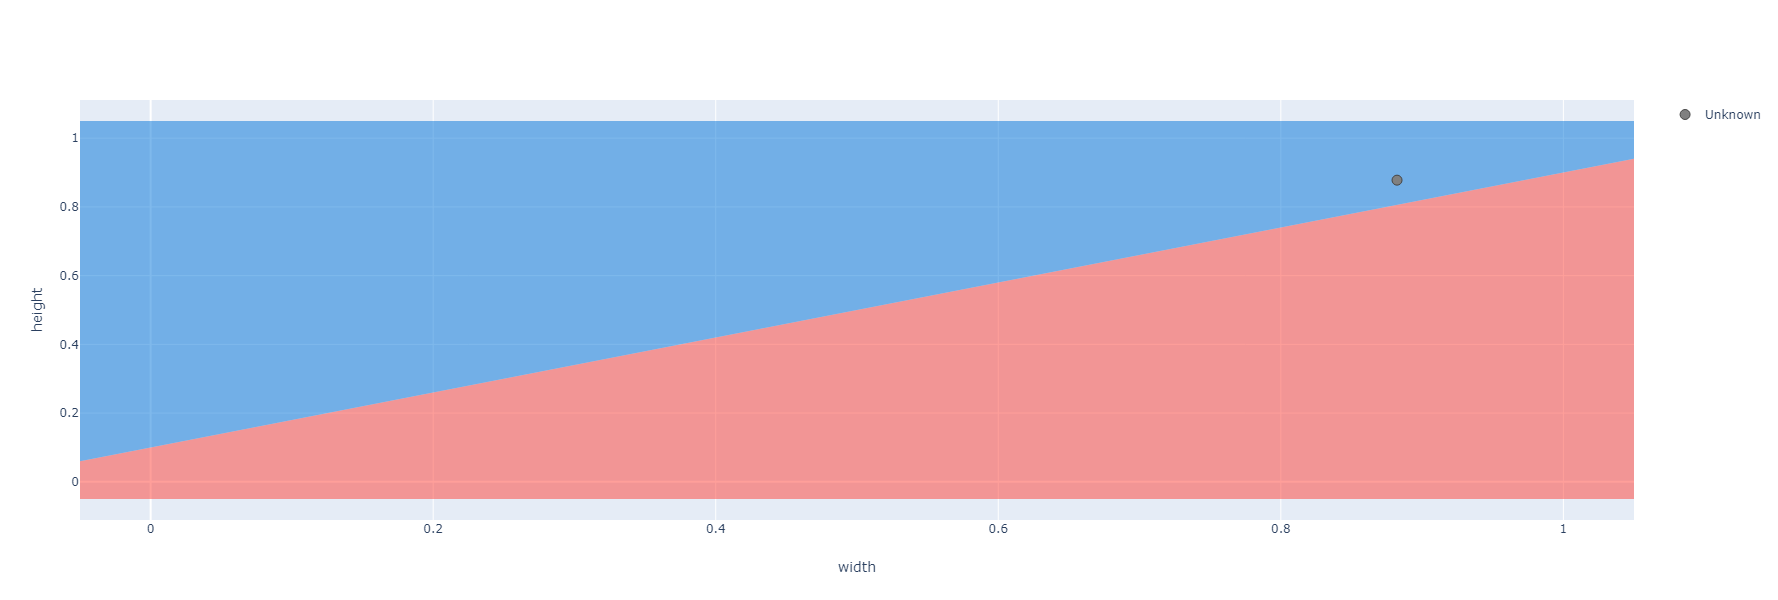

In [57]:
new_data = draw_uniform_data(1, (0,1), (0,1))
plotter.update_data_plots(new_data)
plotter.enable_data_points()
plotter()

In [58]:
def predict_using_linear_model(lin_model, data, class_names):
    label_ids = (lin_model(data[:,0]) > data[:,1]).astype(int)
    return np.asarray(class_names)[label_ids]

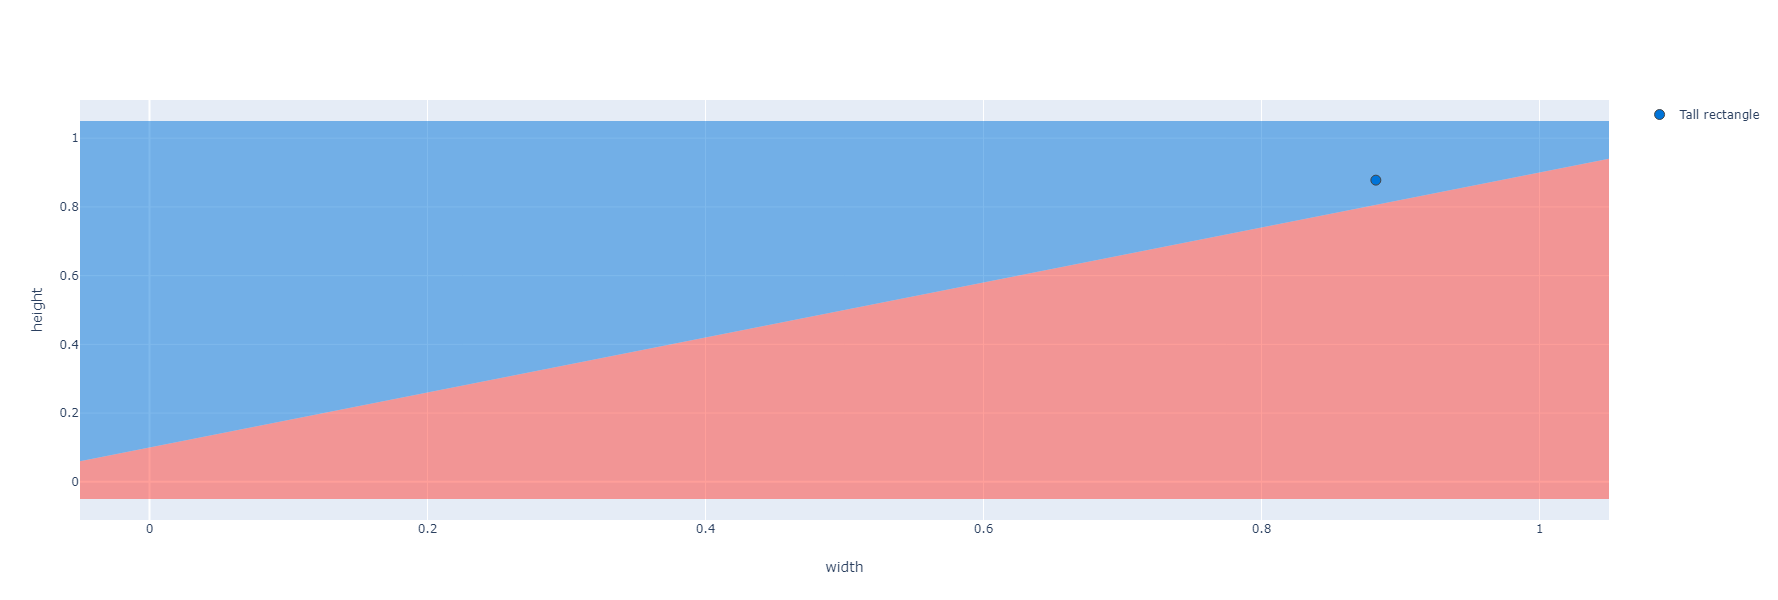

In [59]:
labels = predict_using_linear_model(lin_model, new_data, class_names)
plotter.update_data_plots(new_data, labels, unq_classes=class_names[::-1])
plotter()

## Hvordan forbedre modellen?

For å finne ut hvordan modellen må endres kan vi definere en *feilfunkson* $E$ og bruke de deriverte av denne funksjonen mht parametere i modellen vår. Den deriverte for en parameter vil peke i retningen vi må endre parameteren for å redusere verdien av feilfunksjonen.

$$
\frac{\partial}{\partial w_i}E(modell, data, klasser)
$$
Hvor modellen er en funksjon av $w_0, w_1,...,w_n$

### Psuedo-algoritme for veiledet læring ved "gradient descent" 

1. Start med en tilfeldig konfigurasjon av modellen
2. Beregn de deriverte (aka gradientene, derav "gradient descent")
3. Bruk disse for å oppdatere modellen
4. Iterer steg 1-3 frem til endringene av modellen fra et steg til det neste blir for små (eller et annet stopp-kriterium er nådd)

<center> <img src="../images/gradient-descent.jpg"/> </center>

La oss teste dette opp boks-dataen vår. Vi vet at den korrekte linjen for å skille høye og vide rektangler vil være:
$$y = w_0*x + w_1 = 1 * x + 0 = x$$

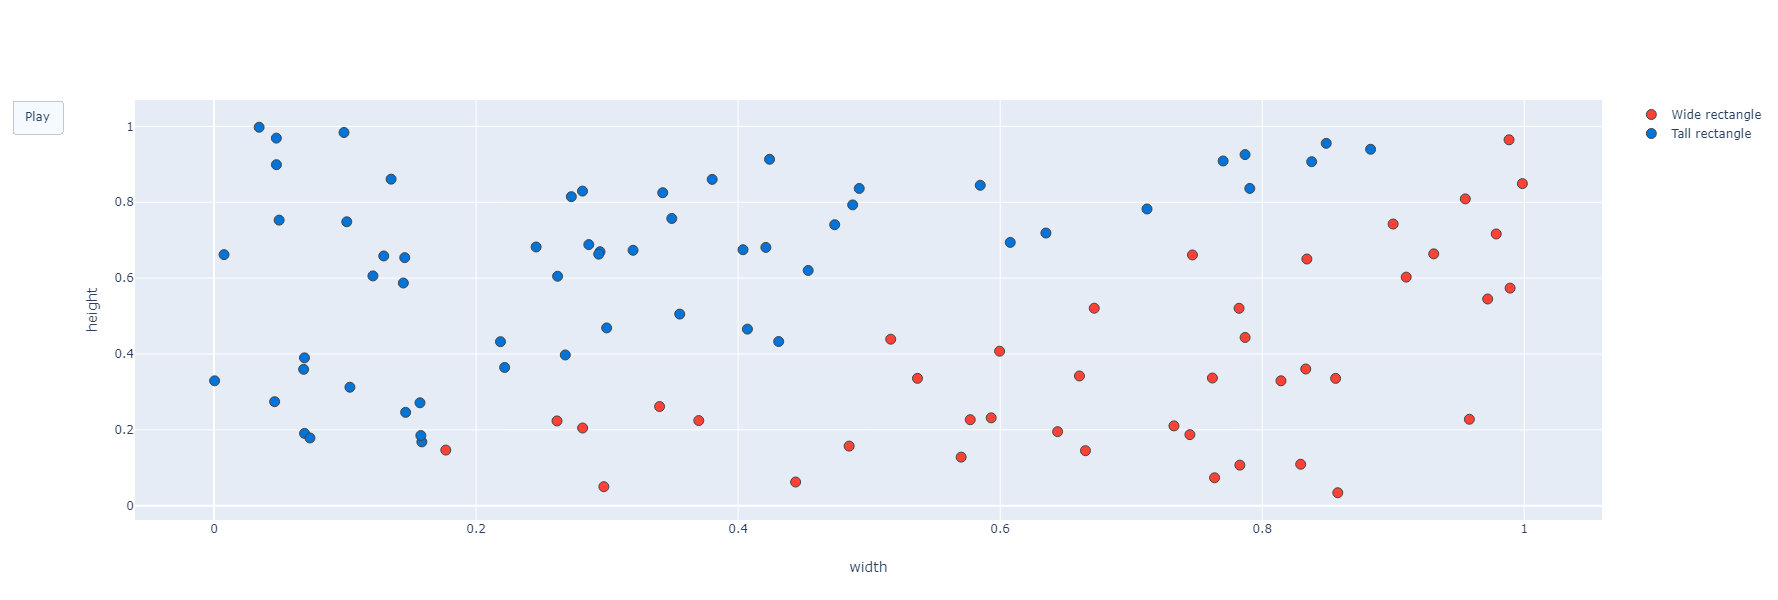

In [244]:
gradient_descent_animation((0, 1), (0, 1), w_real=[1, -1, 0], w_initial=[-0.5, -1, 0.8], lr=1, layout=layout, class_names=class_names, inv_class_names_for_plot=True)